In this notebook we will train a Core/Readout model on data from Hoefling et al., 2024: ["A chromatic feature detector in the retina signals visual context changes"](https://elifesciences.org/articles/86860).

We will closely follow the structure of our unified training script, `openretina.cli.train.py`, including using Hydra to import and examine model config files. 

Note that using `openretina.cli.train.py`, and the corresponding command `openretina train` is the recommended way to run model training, as for some configurations it can take some time. 


# Imports

In [ ]:
import logging
import os

import hydra
import lightning
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from einops import rearrange

from openretina.data_io.base import compute_data_info
from openretina.data_io.cyclers import LongCycler, ShortCycler
from openretina.data_io.hoefling_2024.dataloaders import natmov_dataloaders_v2
from openretina.data_io.hoefling_2024.responses import filter_responses, make_final_responses
from openretina.data_io.hoefling_2024.stimuli import movies_from_pickle
from openretina.eval.metrics import correlation_numpy, feve
from openretina.models.core_readout import CoreReadout
from openretina.utils.file_utils import get_local_file_path
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from openretina.utils.plotting import (
    numpy_to_mp4_video,
)

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)  # to display logs in jupyter

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=30)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's import also the global config file for this model using hydra.

In [2]:
with hydra.initialize(config_path=os.path.join("..", "configs"), version_base="1.3"):
    cfg = hydra.compose(config_name="hoefling_2024_core_readout_low_res.yaml")

# Loading data

The first step in loading data is determining from where it will be fetched / stored.

Let's see how this is handled in the configs:

In [3]:
pp.pprint(cfg.data)

{   'data_dir': '${data.root_dir}/euler_data/',
    'movies_path': 'https://gin.g-node.org/teulerlab/open-retina/raw/master/stimuli/eulerlab/rgc_natstim_18x16_joint_normalized_2024-01-11.pkl',
    'output_dir': '${data.root_dir}/openretina_assets/runs',
    'responses_path': 'https://gin.g-node.org/teulerlab/open-retina/raw/master/responses/eulerlab/rgc_natstim_2024-08-14.h5',
    'root_dir': '???'}


The config contains the path from where files will be downloaded, and also requires the `root_dir` to be set by the user: this is the directory where the data will be stored, and where also model logs and checkpoints will end up.

When using the training script, if root_dir is not set by the user in the config files or somewhere in the script, this will cause an error.

The `root_dir` is also what the package will use in place of the default openretina cache folder. Let's set both here:

In [4]:
your_chosen_root_folder = "/Data"  # Change this with your desired path.

cfg.data.root_dir = your_chosen_root_folder

os.environ["OPENRETINA_CACHE_DIRECTORY"] = your_chosen_root_folder

## Stimuli

Loading of the stimuli is achieved, in the training script, via:
```
movies_dict = hydra.utils.call(cfg.data_io.stimuli)
```

Let's unpack it here.

In [5]:
pp.pprint(cfg.data_io.stimuli)

{   '_convert_': 'object',
    '_target_': 'openretina.data_io.hoefling_2024.stimuli.movies_from_pickle',
    'file_path': {   '_convert_': 'object',
                     '_target_': 'openretina.utils.file_utils.get_local_file_path',
                     'cache_folder': '${data.data_dir}',
                     'file_path': '${data.movies_path}'}}


In [6]:
movies_path = get_local_file_path(file_path=cfg.data.movies_path, cache_folder=cfg.data.data_dir)

movies_dict = movies_from_pickle(movies_path)

2025-02-05 16:13:50,022 - INFO - Target file for https://gin.g-node.org//teulerlab/open-retina/raw/master/stimuli/eulerlab/rgc_natstim_18x16_joint_normalized_2024-01-11.pkl already exists at /Data/euler_data/rgc_natstim_18x16_joint_normalized_2024-01-11.pkl.


In [7]:
pp.pprint(movies_dict)

MoviesTrainTestSplit(train=numpy.ndarray(shape=(2, 16200, 18, 16)),
                     test=numpy.ndarray(shape=(2, 750, 18, 16)),
                     stim_id=None,
                     random_sequences=numpy.ndarray(shape=(108, 20)),
                     norm_mean=nan,
                     norm_std=nan)


Let us also visualize a few seconds of the training video:

In [8]:
numpy_to_mp4_video(movies_dict.train[:, :300, ...])

## Responses

In the training script, responses are loaded through:

```
neuron_data_dict = hydra.utils.call(cfg.data_io.responses)
```

Let's unpack it here.

In [9]:
pp.pprint(cfg.data_io.responses)

{   '_convert_': 'object',
    '_target_': 'openretina.data_io.hoefling_2024.responses.make_final_responses',
    'data_dict': {   '_convert_': 'object',
                     '_target_': 'openretina.data_io.hoefling_2024.responses.filter_responses',
                     'all_responses': {   '_convert_': 'object',
                                          '_target_': 'openretina.utils.h5_handling.load_h5_into_dict',
                                          'file_path': {   '_convert_': 'object',
                                                           '_target_': 'openretina.utils.file_utils.get_local_file_path',
                                                           'cache_folder': '${data.data_dir}',
                                                           'file_path': '${data.responses_path}'}},
                     'cell_types_list': '${quality_checks.cell_types_list}',
                     'chirp_qi': '${quality_checks.chirp_qi}',
                     'classifier_confidenc

In the config for the responses there are a few references to the config for the quality checks, which is used to filter the responses. Let's visualize it:

In [10]:
pp.pprint(cfg.quality_checks)

{   'cell_types_list': list(len=32),
    'chirp_qi': 0.35,
    'classifier_confidence': 0.25,
    'd_qi': 0.6,
    'filter_cell_types': True,
    'filter_counts': False,
    'qi_logic': 'or',
    'verbose': True}


In [11]:
responses_path = get_local_file_path(file_path=cfg.data.responses_path, cache_folder=cfg.data.data_dir)

responses_dict = load_h5_into_dict(file_path=responses_path)

filtered_responses_dict = filter_responses(responses_dict, **cfg.quality_checks)

final_responses = make_final_responses(filtered_responses_dict, response_type="natural")

2025-02-05 16:13:50,546 - INFO - Target file for https://gin.g-node.org//teulerlab/open-retina/raw/master/responses/eulerlab/rgc_natstim_2024-08-14.h5 already exists at /Data/euler_data/rgc_natstim_2024-08-14.h5.


Loading HDF5 file contents:   0%|          | 0/2077 [00:00<?, ?item/s]

Original dataset contains 7863 neurons over 67 fields
 ------------------------------------ 
Dropped 0 fields that did not contain the target cell types (67 remaining)
Overall, dropped 3034 neurons of non-target cell types (-38.59%).
 ------------------------------------ 
Dropped 0 fields with quality indices below threshold (67 remaining)
Overall, dropped 980 neurons over quality checks (-20.29%).
 ------------------------------------ 
Dropped 0 fields with classifier confidences below 0.25
Overall, dropped 705 neurons with classifier confidences below 0.25 (-18.32%).
 ------------------------------------ 
 ------------------------------------ 
Final dataset contains 3144 neurons over 67 fields
Total number of cells dropped: 4719 (-60.02%)


Upsampling natural spikes traces to get final responses.:   0%|          | 0/67 [00:00<?, ?it/s]

Here is how the final responses will be organised:

In [12]:
pp.pprint(final_responses)

{   'session_1_ventral1_20200226': ResponsesTrainTestSplit(train=numpy.ndarray(shape=(80, 16200)),
                                                           test=numpy.ndarray(shape=(80, 750)),
                                                           test_by_trial=numpy.ndarray(shape=(80, 750, 3)),
                                                           stim_id='natural',
                                                           session_kwargs={   'eye': 'left',
                                                                              'group_assignment': numpy.ndarray(shape=(80,)),
                                                                              'roi_ids': numpy.ndarray(shape=(80,)),
                                                                              'roi_mask': numpy.ndarray(shape=(64, 64)),
                                                                              'scan_sequence_idx': 18}),
    'session_1_ventral1_20200528': ResponsesTrainTestSpli

# Creating dataloaders

The corresponding code in `train.py` is:
```
dataloaders = hydra.utils.instantiate(
        cfg.dataloader,
        neuron_data_dictionary=neuron_data_dict,
        movies_dictionary=movies_dict,
    )
```

In [13]:
pp.pprint(cfg.dataloader)

{   '_convert_': 'object',
    '_target_': 'openretina.data_io.hoefling_2024.dataloaders.natmov_dataloaders_v2',
    'allow_over_boundaries': True,
    'batch_size': 128,
    'train_chunk_size': 50,
    'validation_clip_indices': list(len=15)}


In [14]:
dataloaders = natmov_dataloaders_v2(
    neuron_data_dictionary=final_responses,
    movies_dictionary=movies_dict,
    allow_over_boundaries=True,
    batch_size=128,
    train_chunk_size=50,
    validation_clip_indices=cfg.dataloader.validation_clip_indices,
)

Creating movie dataloaders:   0%|          | 0/67 [00:00<?, ?it/s]

In [15]:
pp.pprint(dataloaders)

{   'test': {   'session_1_ventral1_20200226': torch.utils.data.DataLoader(Dataset: MovieDataSet with 80 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_ventral1_20200528': torch.utils.data.DataLoader(Dataset: MovieDataSet with 42 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_ventral1_20200707': torch.utils.data.DataLoader(Dataset: MovieDataSet with 74 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_ventral1_20201021': torch.utils.data.DataLoader(Dataset: MovieDataSet with 32 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_ventral1_20201030': torch.utils.data.DataLoader(Dataset: MovieDataSet with 40 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_ventral1_20210929': torch.utils.data.DataLoader(Dataset: MovieDataSet with 48 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_v

Let's also compute `data_info`, which is used to initialise certain model components and to save important metadata about stimuli and responses within the model.

In [16]:
data_info = compute_data_info(neuron_data_dictionary=final_responses, movies_dictionary=movies_dict)

pp.pprint(data_info)

{   'input_shape': (2, 18, 16),
    'movie_norm_dict': {'default': {'norm_mean': nan, 'norm_std': nan}},
    'n_neurons_dict': {   'session_1_ventral1_20200226': 80,
                          'session_1_ventral1_20200528': 42,
                          'session_1_ventral1_20200707': 74,
                          'session_1_ventral1_20201021': 32,
                          'session_1_ventral1_20201030': 40,
                          'session_1_ventral1_20210929': 48,
                          'session_1_ventral1_20210930': 26,
                          'session_1_ventral2_20200302': 41,
                          'session_1_ventral2_20200707': 56,
                          'session_1_ventral2_20201021': 39,
                          'session_1_ventral2_20201022': 42,
                          'session_1_ventral2_20201030': 84,
                          'session_1_ventral2_20201117': 46,
                          'session_1_ventral2_20210910': 44,
                          'session_1_vent

# Model initialisation

Relevant `train.py` section:
```
cfg.model.n_neurons_dict = data_info["n_neurons_dict"]

model = hydra.utils.instantiate(cfg.model, data_info=data_info)
```

The config for the model will contain all the relevant hyperparameters for it:

In [17]:
pp.pprint(cfg.model)

{   '_convert_': 'object',
    '_target_': 'openretina.models.core_readout.CoreReadout',
    'core_gamma_hidden': 0.0,
    'core_gamma_in_sparse': 0.0,
    'core_gamma_input': 0.0,
    'core_gamma_temporal': 40.0,
    'core_hidden_padding': True,
    'core_input_padding': False,
    'cut_first_n_frames_in_core': 0,
    'downsample_input_kernel_size': None,
    'dropout_rate': 0.0,
    'hidden_channels': [16, 16],
    'in_shape': [2, 150, 18, 16],
    'learning_rate': 0.01,
    'maxpool_every_n_layers': None,
    'n_neurons_dict': '???',
    'readout_bias': True,
    'readout_gamma': 0.4,
    'readout_gaussian_masks': True,
    'readout_gaussian_mean_scale': 6.0,
    'readout_gaussian_var_scale': 4.0,
    'readout_positive': True,
    'readout_scale': True,
    'spatial_kernel_sizes': [11, 5],
    'temporal_kernel_sizes': [21, 11]}


As you can see, the value for `n_neurons_dict` is missing, and needs to be set from data_info.

In [18]:
n_neurons_dict = data_info["n_neurons_dict"]

model = CoreReadout(
    in_shape=(2, 150, 18, 16),
    hidden_channels=(16, 16),
    temporal_kernel_sizes=(21, 11),
    spatial_kernel_sizes=(11, 5),
    n_neurons_dict=n_neurons_dict,
    core_gamma_hidden=0.0,
    core_gamma_in_sparse=0.0,
    core_gamma_input=0.0,
    core_gamma_temporal=40.0,
    core_hidden_padding=True,
    core_input_padding=False,
    cut_first_n_frames_in_core=0,
    downsample_input_kernel_size=None,
    dropout_rate=0.0,
    learning_rate=0.01,
    maxpool_every_n_layers=None,
    readout_bias=True,
    readout_gamma=0.4,
    readout_gaussian_masks=True,
    readout_gaussian_mean_scale=6.0,
    readout_gaussian_var_scale=4.0,
    readout_positive=True,
    readout_scale=True,
    data_info=data_info,
)

2025-02-05 16:13:58,864 - INFO - in_shape_readout=torch.Size([16, 130, 8, 6])


# Training

With data imported, models initialised and dataloaders set up, we can turn to training. 

```
log_folder = os.path.join(cfg.data.output_dir, cfg.exp_name)
os.makedirs(log_folder, exist_ok=True)
logger_array = []
for _, logger_params in cfg.logger.items():
    logger = hydra.utils.instantiate(logger_params, save_dir=log_folder)
    logger_array.append(logger)

callbacks = [
    hydra.utils.instantiate(callback_params) for callback_params in cfg.get("training_callbacks", {}).values()
]

trainer = hydra.utils.instantiate(cfg.trainer, logger=logger_array, callbacks=callbacks)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
```

This section is a bit more involved in `train.py`, to leave flexibility for different loggers and callbacks configurations. We are going to keep it simple here.

Let's first initialise a simple tensorboard logger:

In [19]:
pp.pprint(cfg.logger)

{   'csv': {   '_target_': 'lightning.pytorch.loggers.csv_logs.CSVLogger',
               'name': 'csv/',
               'prefix': '',
               'version': '${now:%Y-%m-%d_%H-%M-%S}'},
    'tensorboard': {   '_target_': 'lightning.pytorch.loggers.TensorBoardLogger',
                       'name': 'tensorboard/',
                       'version': '${now:%Y-%m-%d_%H-%M-%S}'}}


In [20]:
log_save_path = os.path.join(cfg.data.output_dir, "notebook_example")
os.makedirs(log_save_path, exist_ok=True)

logger = lightning.pytorch.loggers.TensorBoardLogger(
    name="tensorboard/",
    save_dir=log_save_path,
)

Then some training callbacks (i.e. utility functions that will be called during training):

In [21]:
pp.pprint(cfg.training_callbacks)

{   'early_stopping': {   '_target_': 'lightning.pytorch.callbacks.EarlyStopping',
                          'check_finite': False,
                          'min_delta': 0.001,
                          'mode': 'max',
                          'monitor': 'val_correlation',
                          'patience': 10,
                          'strict': True,
                          'verbose': True},
    'lr_monitor': {   '_target_': 'lightning.pytorch.callbacks.LearningRateMonitor',
                      'log_momentum': True,
                      'log_weight_decay': True,
                      'logging_interval': 'epoch'},
    'model_checkpoint': {   '_target_': 'lightning.pytorch.callbacks.ModelCheckpoint',
                            'auto_insert_metric_name': True,
                            'dirpath': '${data.output_dir}/${exp_name}/checkpoints/${now:%Y-%m-%d_%H-%M-%S}',
                            'every_n_epochs': None,
                            'every_n_train_steps': None,
 

In [22]:
early_stopping = lightning.pytorch.callbacks.EarlyStopping(
    monitor="val_correlation",
    patience=10,
    mode="max",
    verbose=False,
    min_delta=0.001,
)

lr_monitor = lightning.pytorch.callbacks.LearningRateMonitor(logging_interval="epoch")

model_checkpoint = lightning.pytorch.callbacks.ModelCheckpoint(
    monitor="val_correlation", mode="max", save_weights_only=False
)

We can finally instantiate the trainer

In [23]:
pp.pprint(cfg.trainer)

{   '_target_': 'lightning.Trainer',
    'accumulate_grad_batches': 1,
    'default_root_dir': '${data.output_dir}',
    'deterministic': 'warn',
    'gradient_clip_val': 1,
    'max_epochs': 100,
    'precision': '32-true'}


In [24]:
trainer = lightning.Trainer(max_epochs=100, logger=logger, callbacks=[early_stopping, lr_monitor, model_checkpoint])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finally, we can start training. Before it though, we can initialise the tensorboard jupyter integration, to visualize how training progresses.

Run the following cell once or twice until the tensorboard extension UI shows up. Once is shows, note that at the beginning it will show no data (unless you have run this notebook before), because we have not started the trainer yet.

When you run the cell containing `trainer.fit` you can then come back to the tensorboard extension, reload the window *within the extension* by clicking the refresh icon in the top right, and follow the training.

In [25]:
%reload_ext tensorboard

%tensorboard --logdir {log_save_path}

Reusing TensorBoard on port 6006 (pid 20927), started 0:16:35 ago. (Use '!kill 20927' to kill it.)

The only last important step before calling the trainer is to convert the dictionary of dataloaders we have into a unified iterator that will cycle through all sessions during training and evaluation:

In [26]:
train_loader = LongCycler(dataloaders["train"])
val_loader = ShortCycler(dataloaders["validation"])

And we are finally ready to train:

In [27]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                        | Params | Mode 
-------------------------------------------------------------------------
0 | core             | SimpleCoreWrapper           | 12.4 K | train
1 | readout          | MultiGaussianReadoutWrapper | 66.0 K | train
2 | loss             | PoissonLoss3d               | 0      | train
3 | correlation_loss | CorrelationLoss3d           | 0      | train
-------------------------------------------------------------------------
78.4 K    Trainable params
0         Non-trainable params
78.4 K    Total params
0.314     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Evaluation

Once the model is done training, we can turn to evaluation.

First, let's still use the trainer to see the poisson and correlation performance on each of the dataloaders.

In [28]:
test_loader = ShortCycler(dataloaders["test"])
trainer.test(model, dataloaders=[train_loader, val_loader, test_loader], ckpt_path="best")

Restoring states from the checkpoint path at /Data/openretina_assets/runs/notebook_example/tensorboard/version_4/checkpoints/epoch=40-step=5494.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /Data/openretina_assets/runs/notebook_example/tensorboard/version_4/checkpoints/epoch=40-step=5494.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_correlation      │    0.21147805452346802    │    0.25337186455726624    │    0.4874879717826843     │
│         test_loss         │     643.5421752929688     │     359.7204284667969     │    34.933284759521484     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test_loss/dataloader_idx_0': 643.5421752929688,
  'test_correlation/dataloader_idx_0': 0.21147805452346802},
 {'test_loss/dataloader_idx_1': 359.7204284667969,
  'test_correlation/dataloader_idx_1': 0.25337186455726624},
 {'test_loss/dataloader_idx_2': 34.933284759521484,
  'test_correlation/dataloader_idx_2': 0.4874879717826843}]

We can also look at further evals, like the fraction of explainable variance explained for an example session.

In [29]:
# Let's pick an example session
example_session = list(final_responses.keys())[0]

# Extract responses by trial:
responses_by_trial = final_responses[example_session].test_by_trial

responses_by_trial.shape

(80, 750, 3)

In [30]:
# Get the test movie for that session:
test_movie = dataloaders["test"][example_session].dataset.movies

# Pass it through the model: move to gpu and add batch dimension
with torch.no_grad():
    model_predictions = model.forward(test_movie.to(model.device).unsqueeze(0), data_key=example_session)

model_predictions.shape

torch.Size([1, 730, 80])

In [31]:
help(feve)

Help on function feve in module openretina.eval.metrics:

feve(targets: jaxtyping.Float[ndarray, 'frames repeats neurons'], predictions: jaxtyping.Float[ndarray, 'frames repeats neurons'] | jaxtyping.Float[ndarray, 'frames neurons']) -> jaxtyping.Float[ndarray, ' neurons']
    Adapted from neuralpredictors.
    Compute the fraction of explainable variance explained per neuron
    
    Args:
        targets (array-like): Neuron responses (ground truth) over time / different images across repetitions.
        Dimensions: np.array(images/time, num_repeats, num_neurons)
        predictions (array-like): Model predictions to the repeated images, either including or excluding
        repetitions. Dimensions: np.array(images/time, num_repeats, num_neurons) or np.array(images/time, num_neurons)
    Returns:
        FEVe (np.array): the fraction of explainable variance explained per neuron



In [45]:
# We need to reshape the predictions and responses by trial to match what the function expects

feve_score = feve(
    rearrange(responses_by_trial, "neurons time trials -> time trials neurons")[20:],
    model_predictions.squeeze(0).cpu().numpy(),
)

print(f"Average FEVe score for session {example_session}: {feve_score.mean():.2f}")

Average FEVe score for session session_1_ventral1_20200226: 0.39


Finally, we can plot an example neuron's predictions and its ground truth response.

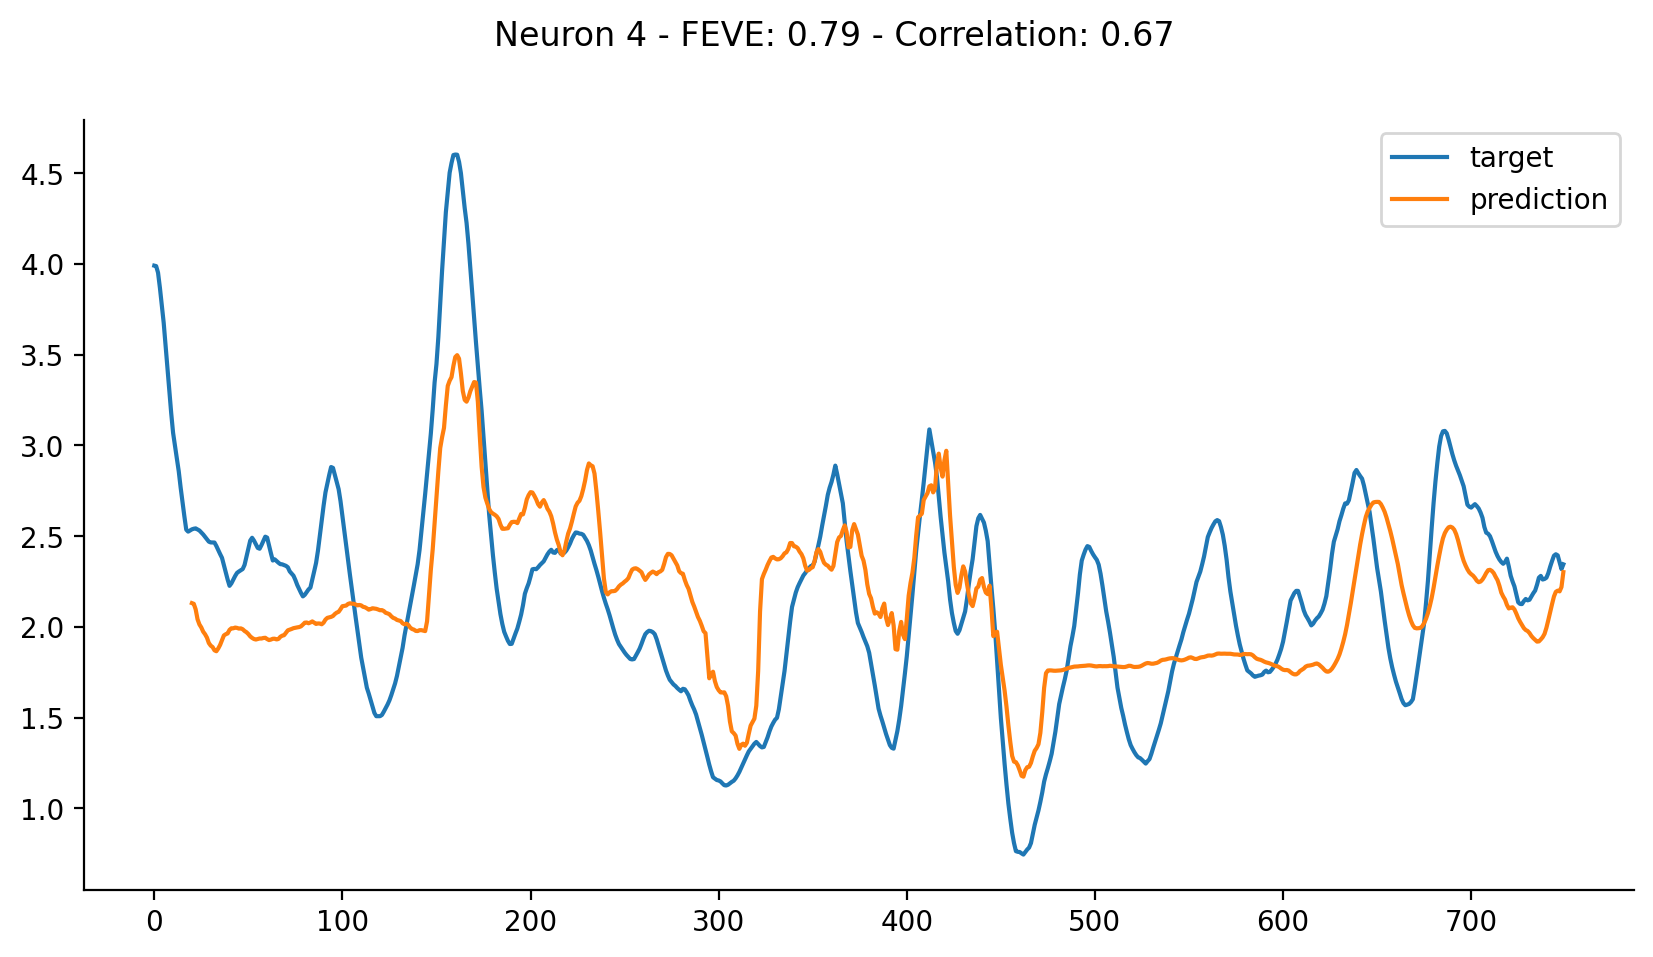

In [48]:
neuron_idx = 4
session_idx = 0


example_session = list(final_responses.keys())[session_idx]

test_sample = next(iter(dataloaders["test"][example_session]))
responses_by_trial = final_responses[example_session].test_by_trial
mean_test_responses = final_responses[example_session].test

input_samples = test_sample.inputs
targets = test_sample.targets

model.eval()
model.cpu()

with torch.no_grad():
    reconstructions = model(input_samples.cpu(), example_session)
reconstructions = reconstructions.cpu().numpy().squeeze()

feve_score = feve(
    rearrange(responses_by_trial, "neurons time trials -> time trials neurons")[20:],
    model_predictions.squeeze(0).cpu().numpy(),
)

correlations = correlation_numpy(mean_test_responses.T[20:], model_predictions.squeeze(0).cpu().numpy(), axis=0)


targets = targets.cpu().numpy().squeeze()
window = 750
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, window), targets[:window, neuron_idx], label="target")
plt.plot(np.arange(20, window), reconstructions[:window, neuron_idx], label="prediction")
plt.suptitle(f"Neuron {neuron_idx} - FEVE: {feve_score[neuron_idx]:.2f} - Correlation: {correlations[neuron_idx]:.2f}")

plt.legend()
sns.despine()

---